<h1><u>  Imports</u> </h1>

In [1]:
import numpy as np
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import mixedlm
import networkx as nx
from sklearn.preprocessing import  StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import seaborn as sns
import ast
from sklearn.utils.class_weight import compute_class_weight
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, SimpleRNN
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

<h1><u>  Load Data</u> </h1>

In [2]:
df = pd.read_csv(r'data/ia_A_preprocessed.tsv',sep='\t')
df.head(20)

,RECORDING_SESSION_LABEL,TRIAL_INDEX,EYE_TRACKED,IA_AREA,IA_BOTTOM,IA_DWELL_TIME,IA_DWELL_TIME_%,IA_FIRST_FIXATION_DURATION,IA_FIRST_FIXATION_INDEX,IA_FIRST_FIXATION_PREVIOUS_FIX_IA,...,q_ind,trial,segmented,section,reading_order_Segmentation,ordered_reading_times,reading_order,average_reading_time_by_length,word_count_by_segment,average_reading_time_by_speed
0,l42_2070,4,Right,10165.0,261,0,0.0000,.,.,.,...,2,3,question,1,"['question', 'a', 'a', 'a', 'a', 'c', 'c', 'c'...","[163, 184, 363, 435, 229, 225, 716, 350, 316, ...","['a', 'c', 'd', 'b']",40.750000,4.0,NaN
1,l42_2070,4,Right,6099.0,261,163,0.0277,163,1,.,...,2,3,question,1,"['question', 'a', 'a', 'a', 'a', 'c', 'c', 'c'...","[163, 184, 363, 435, 229, 225, 716, 350, 316, ...","['a', 'c', 'd', 'b']",40.750000,4.0,NaN
2,l42_2070,4,Right,14231.0,261,0,0.0000,.,.,.,...,2,3,question,1,"['question', 'a', 'a', 'a', 'a', 'c', 'c', 'c'...","[163, 184, 363, 435, 229, 225, 716, 350, 316, ...","['a', 'c', 'd', 'b']",40.750000,4.0,NaN
3,l42_2070,4,Right,28569.0,261,0,0.0000,.,.,.,...,2,3,question,1,"['question', 'a', 'a', 'a', 'a', 'c', 'c', 'c'...","[163, 184, 363, 435, 229, 225, 716, 350, 316, ...","['a', 'c', 'd', 'b']",40.750000,4.0,NaN
4,l42_2070,4,Right,4180.0,492,184,0.0313,184,2,2,...,2,3,a,1,"['question', 'a', 'a', 'a', 'a', 'c', 'c', 'c'...","[163, 184, 363, 435, 229, 225, 716, 350, 316, ...","['a', 'c', 'd', 'b']",173.000000,7.0,NaN
5,l42_2070,4,Right,16720.0,492,229,0.0389,155,5,9,...,2,3,a,1,"['question', 'a', 'a', 'a', 'a', 'c', 'c', 'c'...","[163, 184, 363, 435, 229, 225, 716, 350, 316, ...","['a', 'c', 'd', 'b']",173.000000,7.0,NaN
6,l42_2070,4,Right,10450.0,492,0,0.0000,.,.,.,...,2,3,a,1,"['question', 'a', 'a', 'a', 'a', 'c', 'c', 'c'...","[163, 184, 363, 435, 229, 225, 716, 350, 316, ...","['a', 'c', 'd', 'b']",173.000000,7.0,NaN
7,l42_2070,4,Right,10450.0,492,363,0.0617,157,3,5,...,2,3,a,1,"['question', 'a', 'a', 'a', 'a', 'c', 'c', 'c'...","[163, 184, 363, 435, 229, 225, 716, 350, 316, ...","['a', 'c', 'd', 'b']",173.000000,7.0,NaN
8,l42_2070,4,Right,10450.0,492,435,0.0739,164,4,8,...,2,3,a,1,"['question', 'a', 'a', 'a', 'a', 'c', 'c', 'c'...","[163, 184, 363, 435, 229, 225, 716, 350, 316, ...","['a', 'c', 'd', 'b']",173.000000,7.0,NaN
9,l42_2070,4,Right,10560.0,492,0,0.0000,.,.,.,...,2,3,a,1,"['question', 'a', 'a', 'a', 'a', 'c', 'c', 'c'...","[163, 184, 363, 435, 229, 225, 716, 350, 316, ...","['a', 'c', 'd', 'b']",173.000000,7.0,NaN


In [3]:
surprisal_df  = pd.read_csv(r'data/word_statistics.tsv',sep='\t')
surprisal_df.head(20)


,Wordfreq_Frequency,subtlex_Frequency,gpt2-medium_Surprisal,IA_LABEL,segmented,section
0,6.810359,5.689067,3.987528,It,b,2
1,6.810359,5.689067,3.987528,It,c,2
2,6.810359,5.689067,3.987528,It,d,2
3,6.810359,5.689067,3.987528,It,d,5
4,6.810359,5.689067,3.987528,It,a,7
5,6.810359,5.689067,3.987528,It,b,7
6,6.810359,5.689067,3.987528,It,c,7
7,6.810359,5.689067,3.987528,It,d,7
8,6.810359,5.689067,3.987528,It,b,17
9,6.810359,5.689067,3.987528,It,d,17


<h1><u>Plots of Normlized Time as Fuction of Answers' Order </u> </h1>

In [4]:
def update_pos(row):
    for pos_col in ['pos1', 'pos2', 'pos3', 'pos4']:
        if row[pos_col] == row['a_key']:
            row[pos_col] = 'a'
        elif row[pos_col] == row['b_key']:
            row[pos_col] = 'b'
        elif row[pos_col] == row['c_key']:
            row[pos_col] = 'c'
        elif row[pos_col] == row['d_key']:
            row[pos_col] = 'd'
    return row

# Apply the function to each row


In [5]:
def pos_alignment(df,order_col):
    df_expanded = df.copy()

    if order_col != "reading_order":
        df_expanded[['pos1', 'pos2', 'pos3', 'pos4']] = df_expanded[order_col].str.strip('[]').str.split(expand=True).astype(int)
        df_expanded = df_expanded.apply(update_pos, axis=1)
    else:
        df_expanded[['pos1', 'pos2', 'pos3', 'pos4']] = df_expanded[order_col].str.split(expand=True)
    df_expanded['pos_list'] = df_expanded[['pos1', 'pos2', 'pos3', 'pos4']].values.tolist()
    df_expanded['pos_list'] = df_expanded['pos_list'].apply(lambda x: str(x))

    return df_expanded


In [6]:
def reading_times_alignment(df_expanded, pos_only=True):
    lookup_df = df_expanded[['section', 'segmented', 'average_reading_time_by_length','pos_list']]
    
    # Rename 'segmented' column to match with pos columns for merging
    lookup_df.rename(columns={'segmented': 'pos'}, inplace=True)
    
    # Melt df_expanded to a long format for merging
    df_expanded_melted = df_expanded.melt(id_vars=['section'], value_vars=['pos1', 'pos2', 'pos3', 'pos4'],
                                          var_name='pos_type', value_name='pos')
    df_expanded_melted.drop_duplicates(['section', 'pos_type','pos'], keep='first', inplace=True)
    # Merge with lookup_df to get 'average_reading_time_by_length'
    df_expanded_merged = df_expanded_melted.merge(lookup_df, on=['section', 'pos'], how='left')
    if pos_only:
        mean_values = df_expanded_merged.groupby('pos_type')['average_reading_time_by_length'].mean().reset_index()
        mean_values = mean_values.set_index('pos_type').T
    else:
        mean_values = df_expanded_merged.groupby(['pos_type', 'pos_list'])['average_reading_time_by_length'].mean().reset_index()
   
    return mean_values


In [7]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def plot_time_as_positions(mean_values, plot_name, ax=None):
    positions = {
        'pos1': (0, 2),    # Top
        'pos2': (-2, 0),  # Left
        'pos3': (2, 0),   # Right
        'pos4': (0, -2)  # Bottom 
    }
    
    # Normalize the mean values to range [0, 1] for color mapping
    norm = mcolors.Normalize(vmin=mean_values.min(axis=1).iloc[0], vmax=mean_values.max(axis=1).iloc[0])
    cmap = plt.get_cmap('Oranges')
    
    # If no axis is provided, create a new figure and axis
    if ax is None:
        fig, ax = plt.subplots()
    
    # Define the size of the rectangles and padding
    rect_width = 2
    rect_height = 2    
    
    # Plot each position
    for pos, (x, y) in positions.items():
        value = mean_values.loc['average_reading_time_by_length', pos].astype('int')
        
        # Calculate color intensity using normalization
        color_intensity = norm(value)
        color = cmap(color_intensity)
        
        # Plot a rectangle with the background color
        rect = plt.Rectangle((x - rect_width / 2, y - rect_height / 2), rect_width, rect_height, color=color, edgecolor='black')
        ax.add_patch(rect)
        
        # Add text on top of the rectangle with padding
        ax.text(x, y, f'{value}', ha='center', va='center', fontsize=20, weight='bold')
    
    # Set aspect of the plot to be equal
    ax.set_aspect('equal')
    
    # Set limits and remove axes
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.axis('off')
    
    # Add title
    ax.set_title(plot_name)



In [8]:
def get_plot_time_as_positions(df, plot_name, order_col, pos_only=True):
    df_expanded = pos_alignment(df, order_col)
    mean_values = reading_times_alignment(df_expanded, pos_only=pos_only)
    
    if pos_only:
        plot_time_as_positions(mean_values, plot_name)
    else:
        # Get unique positions
        pos_orders = mean_values['pos_list'].unique()
        
        # Filter out 'None' positions
        pos_orders = [pos_order for pos_order in pos_orders if 'None' not in pos_order]
        
        # Calculate the number of plots
        num_plots = len(pos_orders)
        
        # Determine grid size (e.g., 3x3 grid for 9 plots)
        n_cols = int(np.ceil(np.sqrt(num_plots)))
        n_rows = int(np.ceil(num_plots / n_cols))
        
        # Create figure and subplots
        fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 15))
        
        # Flatten the axs array for easy indexing, in case it's multidimensional
        axs = axs.flatten()
        
        for idx, pos_order in enumerate(pos_orders):
            current_meanvalues = mean_values.loc[mean_values['pos_list'] == pos_order]
            current_meanvalues.drop(['pos_list'], axis=1, inplace=True)
            current_meanvalues = current_meanvalues.set_index('pos_type').T
            
            # Plot on the respective subplot
            plot_time_as_positions(current_meanvalues, plot_name + pos_order, ax=axs[idx])
        
        # Remove any unused subplots
        for i in range(len(pos_orders), len(axs)):
            fig.delaxes(axs[i])
        
        plt.tight_layout()
        plt.show()



In [9]:
relevant_columns =  ["a_key", "b_key", "c_key", "d_key", "answers_order", 'section', 'segmented', 'average_reading_time_by_length'] 
relevant_df = df[relevant_columns]
relevant_df = relevant_df.drop_duplicates(subset=['section', 'segmented'])
relevant_df.head(200)


,a_key,b_key,c_key,d_key,answers_order,section,segmented,average_reading_time_by_length
0,3,0,1,2,[1 2 3 0],1,question,40.750000
4,3,0,1,2,[1 2 3 0],1,a,173.000000
11,3,0,1,2,[1 2 3 0],1,b,147.142857
18,3,0,1,2,[1 2 3 0],1,c,208.714286
25,3,0,1,2,[1 2 3 0],1,d,226.750000
...,...,...,...,...,...,...,...,...
1382,3,2,0,1,[2 3 1 0],40,question,5.000000
1391,3,2,0,1,[2 3 1 0],40,a,53.800000
1396,3,2,0,1,[2 3 1 0],40,b,50.571429
1403,3,2,0,1,[2 3 1 0],40,c,35.000000


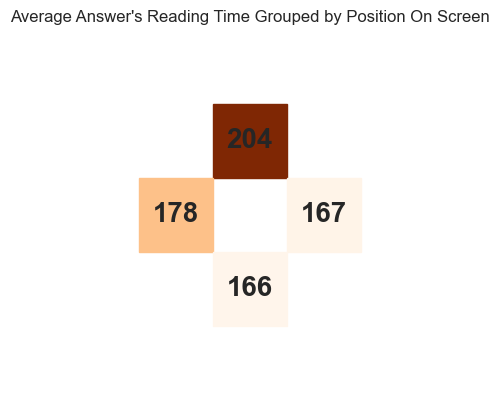

In [10]:
get_plot_time_as_positions(relevant_df, "Average Answer's Reading Time Grouped by Position On Screen",'answers_order', pos_only=True)

As we talked in the meeting we want to plot how long a participant lingered on each answer with regards with its  position on the screen (Meaning the value in answers_order) regardless if the answer itself was of type a, b, c, or d. 

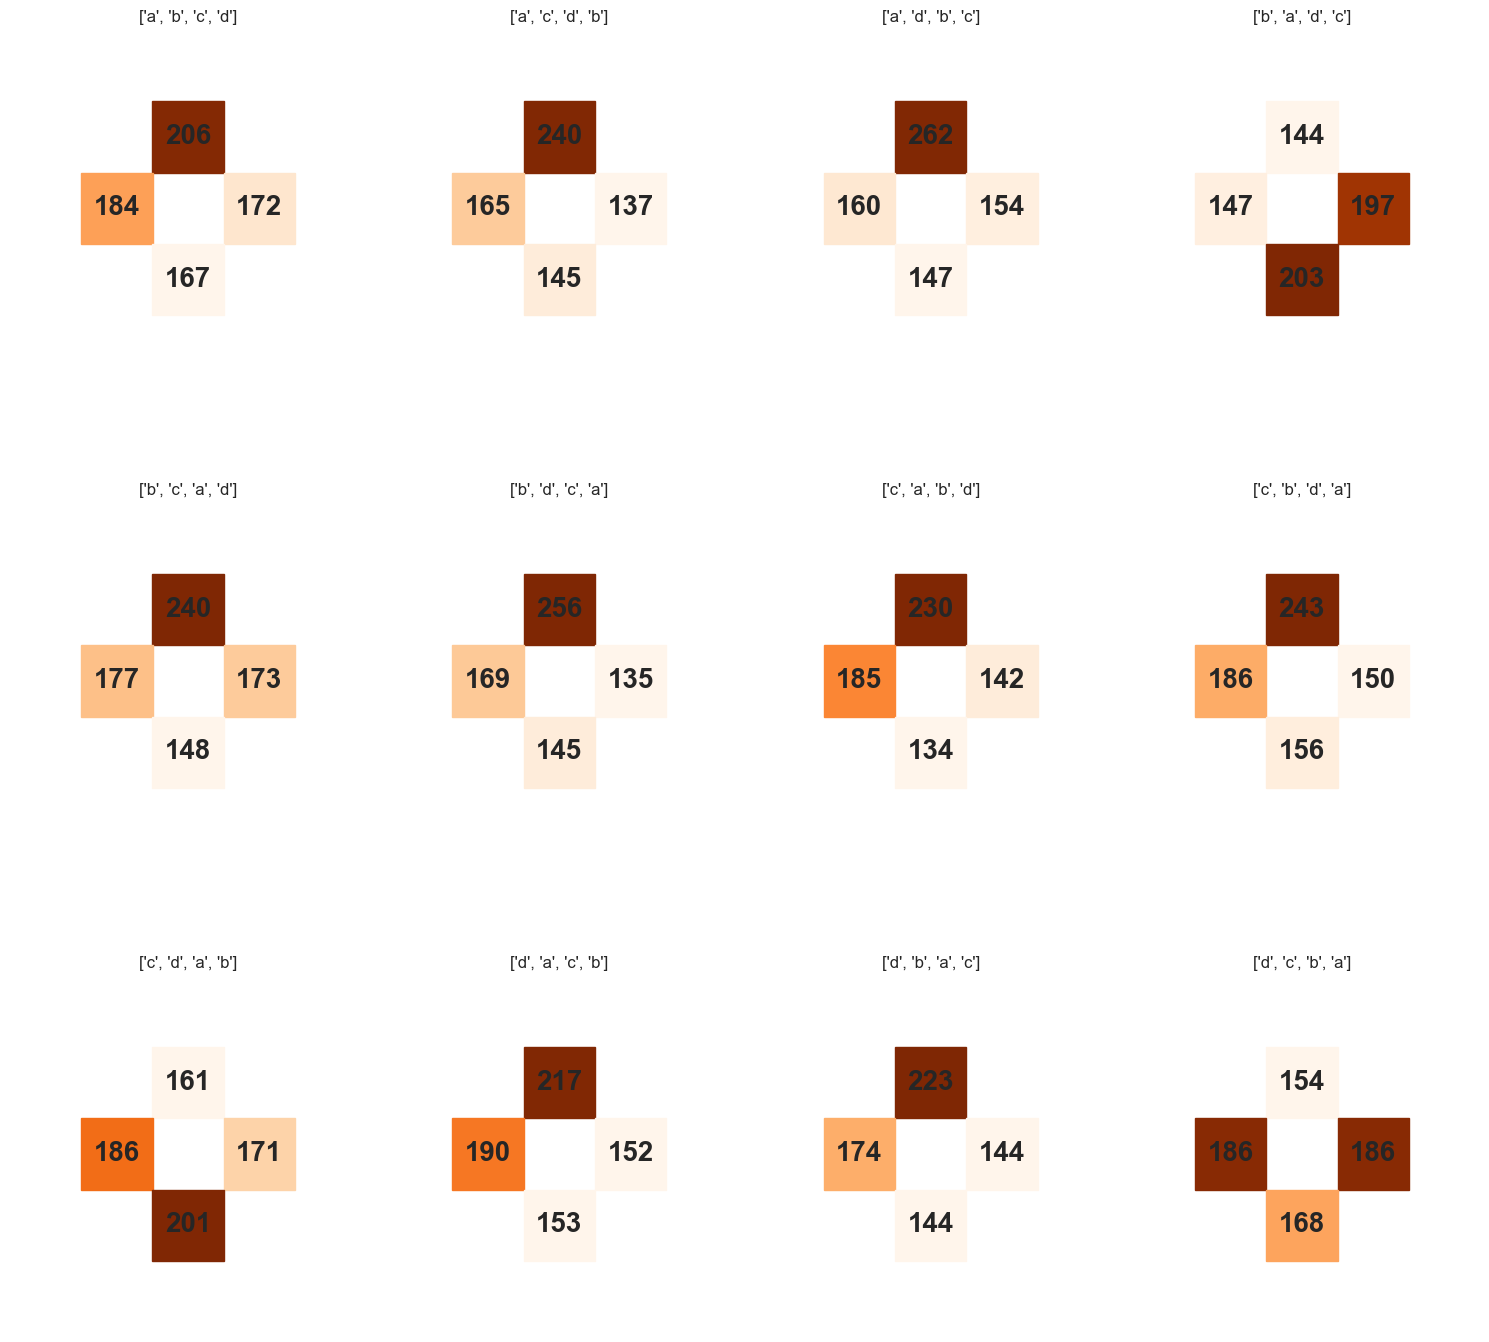

In [12]:
get_plot_time_as_positions(relevant_df, "",order_col="answers_order", pos_only=False)

Statistical analysis of whether the location matters more than the answer type or not

In [93]:
df_expanded = pos_alignment(df, "answers_order")
lookup_df = df_expanded[['section', 'segmented', 'average_reading_time_by_length','pos_list','pos1','pos2','pos3','pos4']]

# mean_values = reading_times_alignment(df_expanded, pos_only=False)
lookup_df.head()


,section,segmented,average_reading_time_by_length,pos_list,pos1,pos2,pos3,pos4
0,1,question,40.75,"['c', 'd', 'a', 'b']",c,d,a,b
1,1,question,40.75,"['c', 'd', 'a', 'b']",c,d,a,b
2,1,question,40.75,"['c', 'd', 'a', 'b']",c,d,a,b
3,1,question,40.75,"['c', 'd', 'a', 'b']",c,d,a,b
4,1,a,173.00,"['c', 'd', 'a', 'b']",c,d,a,b


In [94]:
lookup_df =lookup_df.drop_duplicates()
lookup_df =lookup_df[lookup_df["segmented"] != 'question']
lookup_df.head()


,section,segmented,average_reading_time_by_length,pos_list,pos1,pos2,pos3,pos4
4,1,a,173.000000,"['c', 'd', 'a', 'b']",c,d,a,b
11,1,b,147.142857,"['c', 'd', 'a', 'b']",c,d,a,b
18,1,c,208.714286,"['c', 'd', 'a', 'b']",c,d,a,b
25,1,d,226.750000,"['c', 'd', 'a', 'b']",c,d,a,b
42,2,a,236.222222,"['c', 'a', 'b', 'd']",c,a,b,d


In [97]:
# List of position names corresponding to pos1, pos2, etc.
positions = ['Top', 'Left', 'Right', 'Bottom']

# Melt the DataFrame to unpivot it
df_melted = pd.melt(lookup_df, id_vars=['section'],
                    value_vars=['pos1', 'pos2', 'pos3', 'pos4'],
                    var_name='Position', value_name='type')
# # Map 'Position' column to actual location names
position_map = {'pos1': 'Top', 'pos2': 'Left', 'pos3': 'Right', 'pos4': 'Bottom'}
df_melted['Location'] = df_melted['Position'].map(position_map)
df_melted =df_melted.drop_duplicates()
df_melted = df_melted.drop(columns=['Position'])
lookup_df_c = lookup_df.copy()
lookup_df_c = lookup_df_c.drop(columns=['pos_list','pos1','pos2','pos3','pos4'])
lookup_df_c.rename(columns={'segmented': 'type'}, inplace=True)
merged_df = pd.merge(df_melted, lookup_df_c, on=['section', 'type'])
merged_df = merged_df.sort_values(by=['section', 'type'])




In [98]:
# Assuming df is your DataFrame with columns: 'reading_time', 'location', 'order'

model = ols('average_reading_time_by_length ~ C(Location) + C(type) + C(Location):C(type)', data=merged_df).fit()
anova_results = anova_lm(model)
print(anova_results)

                          df        sum_sq       mean_sq           F  \
C(Location)              3.0  1.675068e+07  5.583560e+06  163.147908   
C(type)                  3.0  6.274139e+05  2.091380e+05    6.110872   
C(Location):C(type)      9.0  2.896174e+06  3.217971e+05    9.402698   
Residual             73909.0  2.529455e+09  3.422391e+04         NaN   

                            PR(>F)  
C(Location)          2.066605e-105  
C(type)               3.759398e-04  
C(Location):C(type)   1.979065e-14  
Residual                       NaN  


In [99]:
# Random intercepts for 'participant' or 'question', for example
model = mixedlm("average_reading_time_by_length ~ C(Location) + C(type)", merged_df, groups=merged_df["section"])
mixed_results = model.fit()
print(mixed_results.summary())

                   Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: average_reading_time_by_length
No. Observations: 73925   Method:             REML                          
No. Groups:       18504   Scale:              20728.8938                    
Min. group size:  3       Log-Likelihood:     -484131.2147                  
Max. group size:  4       Converged:          Yes                           
Mean group size:  4.0                                                       
-----------------------------------------------------------------------------
                           Coef.    Std.Err.    z     P>|z|   [0.025   0.975]
-----------------------------------------------------------------------------
Intercept                  169.761     1.762  96.339  0.000  166.307  173.215
C(Location)[T.Left]          9.710     1.588   6.115  0.000    6.598   12.822
C(Location)[T.Right]        -0.154     1.588  -0.097  0.923   -3.266    2.957
C(Location)[T

As we talked in the meeting we want to plot how long a participant lingered on each answer with regards to the reading order regardless if the answer itself was of type a, b, c, or d. 

In [18]:
relevant_columns =  ["a_key", "b_key", "c_key", "d_key", 'section', 'segmented', 'average_reading_time_by_length','reading_order','answers_order'] 
df_reading_order = df[relevant_columns]
df_reading_order = df_reading_order.drop_duplicates(subset=['section', 'segmented'])
df_reading_order['reading_order'] = df_reading_order['reading_order'].apply(lambda x: f" {''.join(x)}")
df_reading_order['reading_order'] = df_reading_order['reading_order'].apply(lambda x: x.replace("'",""))
df_reading_order['reading_order'] = df_reading_order['reading_order'].apply(lambda x: x.replace(",",""))
df_reading_order['reading_order'] = df_reading_order['reading_order'].apply(lambda x: x.replace("[",""))
df_reading_order['reading_order'] = df_reading_order['reading_order'].apply(lambda x: x.replace("]",""))
df_reading_order.head(200)


,a_key,b_key,c_key,d_key,section,segmented,average_reading_time_by_length,reading_order,answers_order
0,3,0,1,2,1,question,40.750000,a c d b,[1 2 3 0]
4,3,0,1,2,1,a,173.000000,a c d b,[1 2 3 0]
11,3,0,1,2,1,b,147.142857,a c d b,[1 2 3 0]
18,3,0,1,2,1,c,208.714286,a c d b,[1 2 3 0]
25,3,0,1,2,1,d,226.750000,a c d b,[1 2 3 0]
...,...,...,...,...,...,...,...,...,...
1382,3,2,0,1,40,question,5.000000,a c b d,[2 3 1 0]
1391,3,2,0,1,40,a,53.800000,a c b d,[2 3 1 0]
1396,3,2,0,1,40,b,50.571429,a c b d,[2 3 1 0]
1403,3,2,0,1,40,c,35.000000,a c b d,[2 3 1 0]


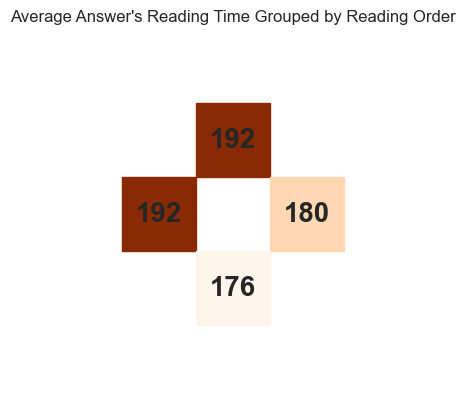

In [19]:
get_plot_time_as_positions(df_reading_order, "Average Answer's Reading Time Grouped by Reading Order",'reading_order', pos_only=True)

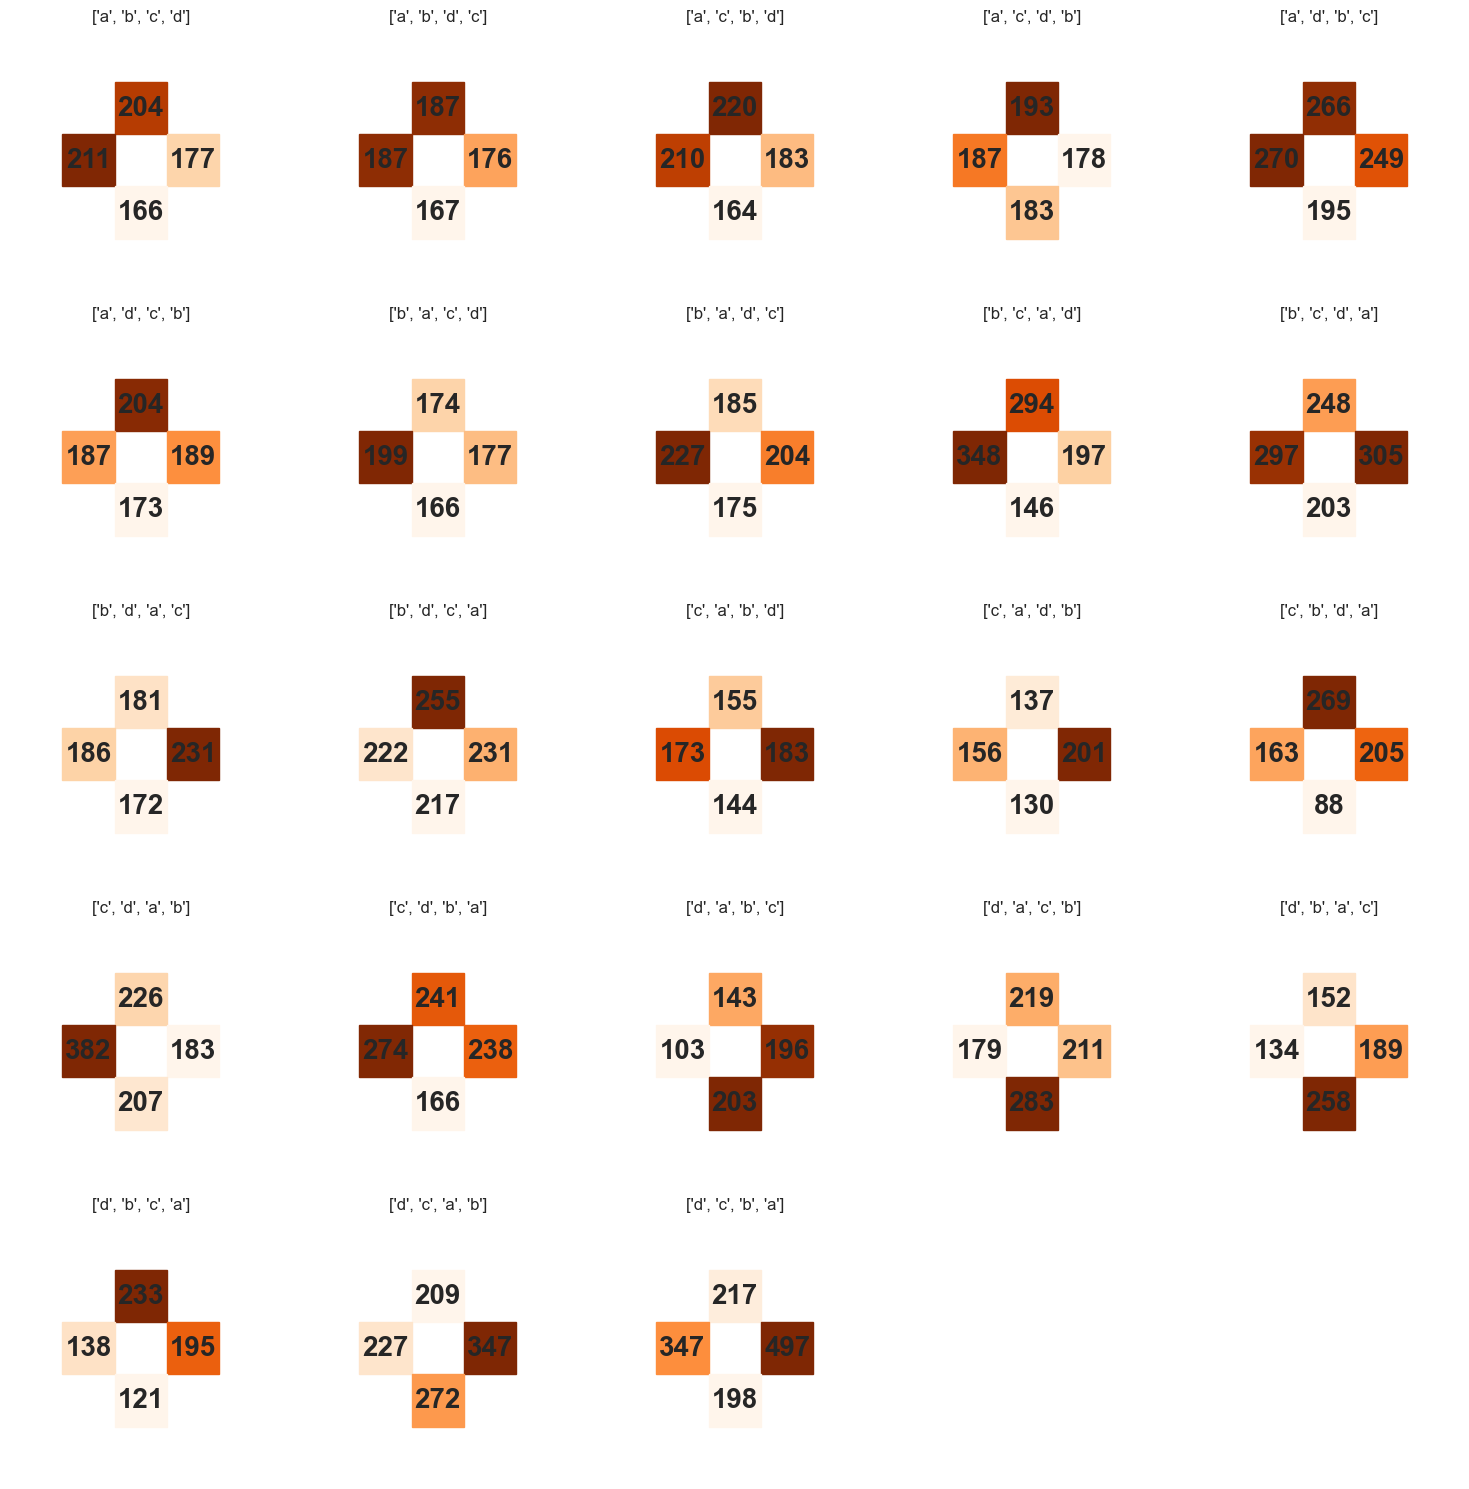

In [20]:
get_plot_time_as_positions(df_reading_order, "",'reading_order', pos_only=False)

In [107]:
relevant_columns =  ["a_key", "b_key", "c_key", "d_key", 'section', 'segmented', 'average_reading_time_by_length','reading_order','answers_order'] 
df_reading_order = df[relevant_columns]
df_reading_order = df_reading_order.drop_duplicates(subset=['section', 'segmented'])
df_reading_order['reading_order'] = df_reading_order['reading_order'].apply(lambda x: f" {''.join(x)}")
df_reading_order['reading_order'] = df_reading_order['reading_order'].apply(lambda x: x.replace("'",""))
df_reading_order['reading_order'] = df_reading_order['reading_order'].apply(lambda x: x.replace(",",""))
df_reading_order['reading_order'] = df_reading_order['reading_order'].apply(lambda x: x.replace("[",""))
df_reading_order['reading_order'] = df_reading_order['reading_order'].apply(lambda x: x.replace("]",""))

In [108]:
df_expanded = pos_alignment(df_reading_order, "reading_order")
lookup_df = df_expanded[['section', 'segmented', 'average_reading_time_by_length','pos_list','pos1','pos2','pos3','pos4']]

lookup_df.head()


,section,segmented,average_reading_time_by_length,pos_list,pos1,pos2,pos3,pos4
0,1,question,40.750000,"['a', 'c', 'd', 'b']",a,c,d,b
4,1,a,173.000000,"['a', 'c', 'd', 'b']",a,c,d,b
11,1,b,147.142857,"['a', 'c', 'd', 'b']",a,c,d,b
18,1,c,208.714286,"['a', 'c', 'd', 'b']",a,c,d,b
25,1,d,226.750000,"['a', 'c', 'd', 'b']",a,c,d,b


In [109]:
lookup_df =lookup_df.drop_duplicates()
lookup_df =lookup_df[lookup_df["segmented"] != 'question']
lookup_df.head()


,section,segmented,average_reading_time_by_length,pos_list,pos1,pos2,pos3,pos4
4,1,a,173.000000,"['a', 'c', 'd', 'b']",a,c,d,b
11,1,b,147.142857,"['a', 'c', 'd', 'b']",a,c,d,b
18,1,c,208.714286,"['a', 'c', 'd', 'b']",a,c,d,b
25,1,d,226.750000,"['a', 'c', 'd', 'b']",a,c,d,b
42,2,a,236.222222,"['a', 'c', 'd', 'b']",a,c,d,b


In [110]:
# List of position names corresponding to pos1, pos2, etc.
positions = ['Top', 'Left', 'Right', 'Bottom']

# Melt the DataFrame to unpivot it
df_melted = pd.melt(lookup_df, id_vars=['section'],
                    value_vars=['pos1', 'pos2', 'pos3', 'pos4'],
                    var_name='Position', value_name='type')
# # Map 'Position' column to actual location names
position_map = {'pos1': 'Top', 'pos2': 'Left', 'pos3': 'Right', 'pos4': 'Bottom'}
df_melted['Reading_Order'] = df_melted['Position'].map(position_map)
df_melted =df_melted.drop_duplicates()
df_melted = df_melted.drop(columns=['Position'])
lookup_df_c = lookup_df.copy()
lookup_df_c = lookup_df_c.drop(columns=['pos_list','pos1','pos2','pos3','pos4'])
lookup_df_c.rename(columns={'segmented': 'type'}, inplace=True)
merged_df = pd.merge(df_melted, lookup_df_c, on=['section', 'type'])
merged_df = merged_df.sort_values(by=['section', 'type'])




In [121]:
merged_df = merged_df.reset_index(drop=True)
merged_df = merged_df.dropna(subset=["average_reading_time_by_length", "Reading_Order", "type", "section"])


In [122]:
# Assuming df is your DataFrame with columns: 'reading_time', 'location', 'order'

model = ols('average_reading_time_by_length ~ C(Reading_Order) + C(type) + C(Reading_Order):C(type)', data=merged_df).fit()
anova_results = anova_lm(model)
print(anova_results)

                               df        sum_sq       mean_sq          F  \
C(Reading_Order)              3.0  3.326370e+06  1.108790e+06  32.182897   
C(type)                       3.0  1.585830e+06  5.286101e+05  15.343037   
C(Reading_Order):C(type)      9.0  1.346088e+06  1.495653e+05   4.341170   
Residual                  71358.0  2.458481e+09  3.445277e+04        NaN   

                                PR(>F)  
C(Reading_Order)          8.858152e-21  
C(type)                   5.631111e-10  
C(Reading_Order):C(type)  1.122892e-05  
Residual                           NaN  


In [123]:
# Random intercepts for 'participant' or 'question', for example
model = mixedlm("average_reading_time_by_length ~ C(Reading_Order) + C(type)", merged_df, groups=merged_df["section"])
mixed_results = model.fit()
print(mixed_results.summary())

                   Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: average_reading_time_by_length
No. Observations: 71374   Method:             REML                          
No. Groups:       18476   Scale:              20383.2095                    
Min. group size:  1       Log-Likelihood:     -467368.5968                  
Max. group size:  4       Converged:          Yes                           
Mean group size:  3.9                                                       
----------------------------------------------------------------------------
                               Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
----------------------------------------------------------------------------
Intercept                      185.703    3.010 61.699 0.000 179.804 191.602
C(Reading_Order)[T.Left]        17.711    1.599 11.077 0.000  14.577  20.844
C(Reading_Order)[T.Right]       11.103    1.842  6.027 0.000   7.492  14.714
C(Reading_Order)[T.

<h1><u>Basic Statistics on Frequency and Surprisal</u> </h1>

In [21]:
# Calculate overall average frequency and surprisal
overall_avg_frequency = surprisal_df[['Wordfreq_Frequency', 'subtlex_Frequency']].mean().mean()
overall_avg_surprisal = surprisal_df['gpt2-medium_Surprisal'].mean()

print(f"Overall Average Frequency: {overall_avg_frequency}")
print(f"Overall Average Surprisal: {overall_avg_surprisal}")

# Calculate average frequency and surprisal for each value in 'segmented'
segmented_avg = surprisal_df.groupby('segmented').agg({
    'Wordfreq_Frequency': 'mean',
    'subtlex_Frequency': 'mean',
    'gpt2-medium_Surprisal': 'mean'
}).rename(columns={
    'Wordfreq_Frequency': 'Avg_Wordfreq_Frequency',
    'subtlex_Frequency': 'Avg_subtlex_Frequency',
    'gpt2-medium_Surprisal': 'Avg_Surprisal'
})

print("\nAverage Frequency and Surprisal by Segment:")
print(segmented_avg)

Overall Average Frequency: 6.027669853809551
Overall Average Surprisal: 2.1729148531663567

Average Frequency and Surprisal by Segment:
           Avg_Wordfreq_Frequency  Avg_subtlex_Frequency  Avg_Surprisal
segmented                                                              
a                        5.762294               6.289249       2.172248
b                        5.762050               6.290760       2.177481
c                        5.782001               6.310761       2.184561
d                        5.778827               6.301028       2.181747
question                 5.857523               6.167199       2.159145


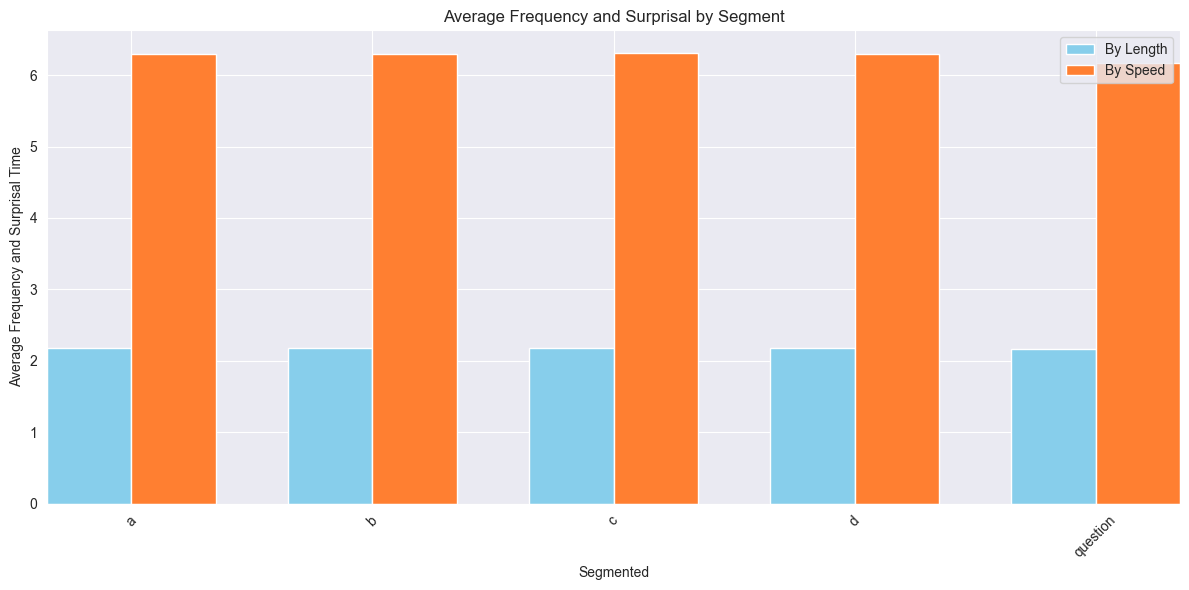

In [22]:
# Prepare data for plotting
segments = segmented_avg.index
avg_length = segmented_avg['Avg_Surprisal']
avg_speed = segmented_avg['Avg_subtlex_Frequency']

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Define bar width and positions
bar_width = 0.35  # Width of the bars
index = np.arange(len(segments))  # The x locations for the groups

# Plot average normalized reading time by length
bars1 = ax.bar(index - bar_width/2, avg_length, bar_width, color='skyblue', label='By Length')

# Plot average normalized reading time by speed
bars2 = ax.bar(index + bar_width/2, avg_speed, bar_width, color='#ff7f31', label='By Speed')

# Customize the plot
ax.set_xlabel('Segmented')
ax.set_ylabel('Average Frequency and Surprisal Time')
ax.set_title('Average Frequency and Surprisal by Segment')
ax.set_xticks(index)
ax.set_xticklabels(segments, rotation=45)
ax.legend()

# Add margin between bars
ax.set_xlim(min(index) - bar_width, max(index) + bar_width)

# Show the plot
plt.tight_layout()
plt.show()

<h1><u>Basic Statistics</u> </h1>

**Note**: since sometimes the subject didn't read the question (we assume they where hunters and didn't feel the need to reread it), not all reading times have a normalization by reading speed which was induced useing the reading time on the question. For those samples the reading time is inf and it was disregarded for the caclulations below.

In [23]:

# Load the data into a DataFrame from a CSV file
df_copy = df.copy()
# Replace inf values with NaN for proper mean calculation
df_copy.replace([np.inf, -np.inf], np.nan, inplace=True)

# Calculate overall average for normalized reading times
overall_avg_length = df_copy['average_reading_time_by_length'].mean()
overall_avg_speed = df_copy['average_reading_time_by_speed'].mean()

print(f"Overall Average Normalized Reading Time by Length: {overall_avg_length}")
print(f"Overall Average Normalized Reading Time by Speed: {overall_avg_speed}")

# Calculate average for normalized reading times for each value in 'segmented'
segmented_avg = df_copy.groupby('segmented').agg({
    'average_reading_time_by_length': 'mean',
    'average_reading_time_by_speed': 'mean'
}).rename(columns={
    'average_reading_time_by_length': 'Avg_Normalized_Time_By_Length',
    'average_reading_time_by_speed': 'Avg_Normalized_Time_By_Speed'
})

print("\nAverage Normalized Reading Times by Segment:")
print(segmented_avg)

Overall Average Normalized Reading Time by Length: 124.65844339081609
Overall Average Normalized Reading Time by Speed: 127.18311749954286

Average Normalized Reading Times by Segment:
           Avg_Normalized_Time_By_Length  Avg_Normalized_Time_By_Speed
segmented                                                             
a                             167.685392                    161.005520
b                             157.598957                    152.404269
c                             155.735865                    176.258861
d                             150.376312                    174.495631
question                       26.290122                     10.717523


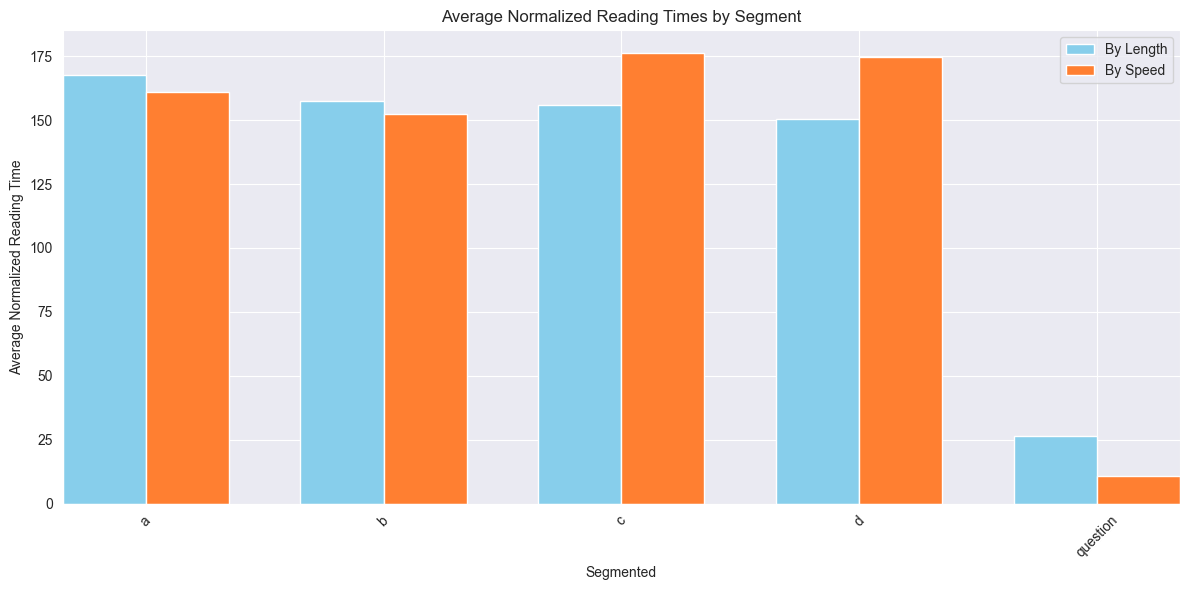

In [24]:
# Prepare data for plotting
segments = segmented_avg.index
avg_length = segmented_avg['Avg_Normalized_Time_By_Length']
avg_speed = segmented_avg['Avg_Normalized_Time_By_Speed']

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Define bar width and positions
bar_width = 0.35  # Width of the bars
index = np.arange(len(segments))  # The x locations for the groups

# Plot average normalized reading time by length
bars1 = ax.bar(index - bar_width/2, avg_length, bar_width, color='skyblue', label='By Length')

# Plot average normalized reading time by speed
bars2 = ax.bar(index + bar_width/2, avg_speed, bar_width, color='#ff7f31', label='By Speed')

# Customize the plot
ax.set_xlabel('Segmented')
ax.set_ylabel('Average Normalized Reading Time')
ax.set_title('Average Normalized Reading Times by Segment')
ax.set_xticks(index)
ax.set_xticklabels(segments, rotation=45)
ax.legend()

# Add margin between bars
ax.set_xlim(min(index) - bar_width, max(index) + bar_width)

# Show the plot
plt.tight_layout()
plt.show()

A chart of reading time for each answer conditional on the subject chosen answer.

In [50]:
# Determine the chosen answer for each section
def determine_chosen_answer(row):
    if row['FINAL_ANSWER'] == row['a_key']:
        return 'a'
    elif row['FINAL_ANSWER'] == row['b_key']:
        return 'b'
    elif row['FINAL_ANSWER'] == row['c_key']:
        return 'c'
    elif row['FINAL_ANSWER'] == row['d_key']:
        return 'd'
    return None

df['CHOSEN_ANSWER'] = df.apply(determine_chosen_answer, axis=1)

# Remove rows where CHOSEN_ANSWER is None
filtered_df = df[df['CHOSEN_ANSWER'].notnull()]

# Select relevant columns and remove duplicates
filtered_df = filtered_df[['section', 'segmented', 'average_reading_time_by_length', 'CHOSEN_ANSWER']].drop_duplicates()

# Aggregate data: calculate average reading time by segmented and chosen answer
average_time = filtered_df.groupby(['segmented', 'CHOSEN_ANSWER']).agg({
    'average_reading_time_by_length': 'mean'
}).rename(columns={
    'average_reading_time_by_length': 'Avg_Normalized_Time_By_Length'
}).reset_index()

# Pivot the table to get the desired 4x4 format
pivot_table = average_time.pivot_table(
    index='CHOSEN_ANSWER',  # Rows are chosen answers
    columns='segmented',    # Columns are segmented values
    values='Avg_Normalized_Time_By_Length',
    fill_value=0            # Fill missing values with 0
).reindex(index=['a', 'b', 'c', 'd'])  # Ensure the rows are in order of chosen answers

# Save the pivot table to a CSV file
pivot_table.to_csv('average_time_by_answer_and_segment.csv', index=True)
pivot_table = pivot_table.astype(int)

# Print the table for review
print(pivot_table)


segmented        a    b    c    d  question
CHOSEN_ANSWER                              
a              174  169  164  157        24
b              248  237  221  228        42
c              279  259  246  252        58
d              321  271  285  267        65


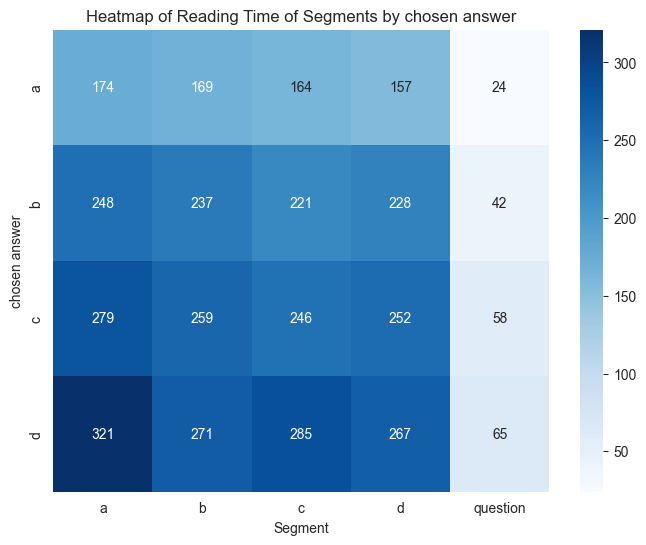

In [51]:
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Segment')  
plt.ylabel('chosen answer')
# Display the plot
plt.title('Heatmap of Reading Time of Segments by chosen answer')
plt.show()

More statistics on reading time divided by different groups. The plots are of bar plots with the variance indicated for each group.

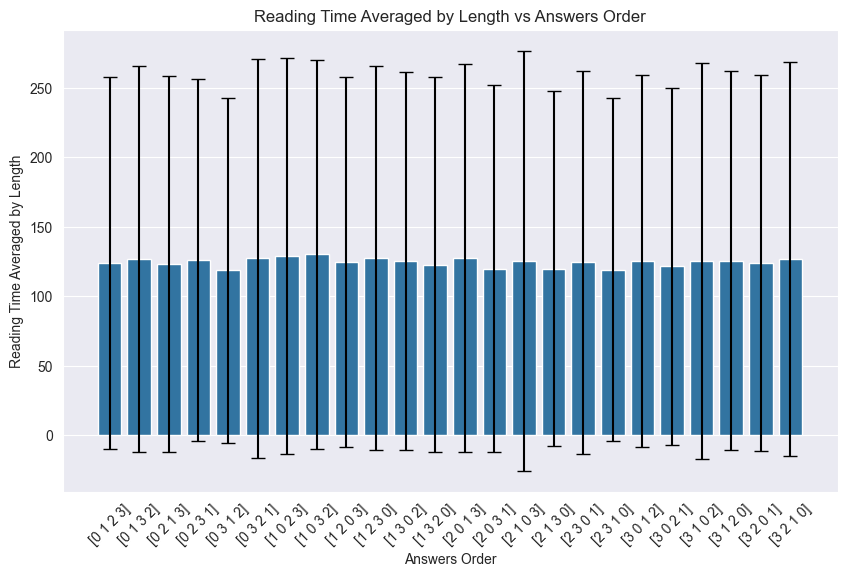

In [90]:
# Group the data by the answers order and calculate mean and std
grouped_df = df.groupby('answers_order')['average_reading_time_by_length'].agg(['mean', 'std']).reset_index()

# Plotting the average reading time
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='answers_order', y='mean', data=grouped_df, capsize=0.1)

# Adding error bars manually using the standard deviation
ax.errorbar(x=grouped_df['answers_order'], 
            y=grouped_df['mean'], 
            yerr=grouped_df['std'], 
            fmt='none', 
            c='black', 
            capsize=5)

# Adding labels and title
plt.xticks(rotation=45)
plt.xlabel('Answers Order')
plt.ylabel('Reading Time Averaged by Length')
plt.title('Reading Time Averaged by Length vs Answers Order')
plt.show()

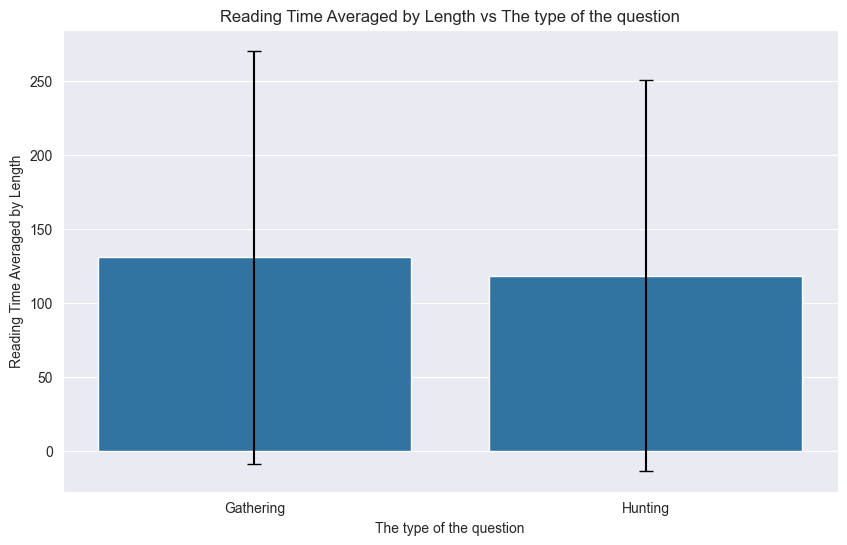

In [84]:
# Group the data by the has_preview and calculate mean and std
grouped_df = df.groupby('has_preview')['average_reading_time_by_length'].agg(['mean', 'std']).reset_index()

# Plotting the average reading time
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='has_preview', y='mean', data=grouped_df, capsize=0.1)

# Adding error bars manually using the standard deviation
ax.errorbar(x=grouped_df['has_preview'], 
            y=grouped_df['mean'], 
            yerr=grouped_df['std'], 
            fmt='none', 
            c='black', 
            capsize=5)

# Adding labels and title
plt.xticks(ticks=[0, 1], labels=['Gathering', 'Hunting'])
plt.xlabel('The type of the question')
plt.ylabel('Reading Time Averaged by Length')
plt.title('Reading Time Averaged by Length vs The type of the question')
plt.show()


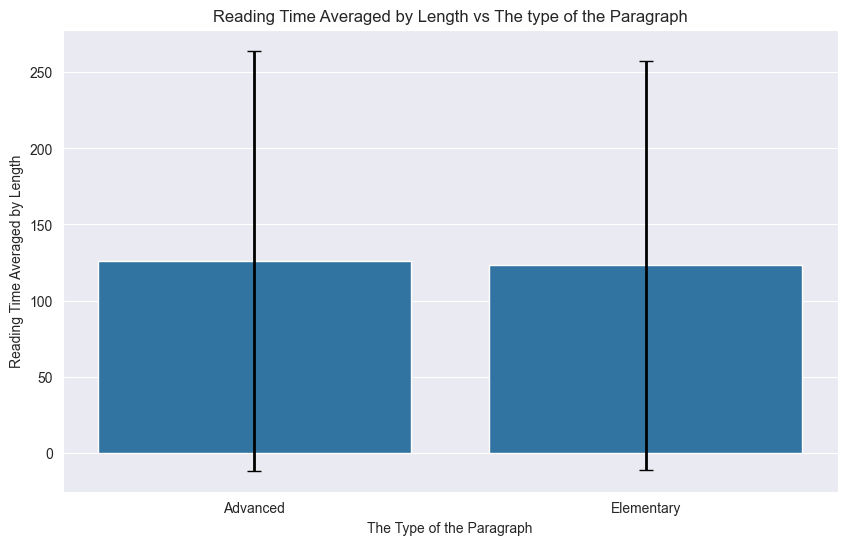

In [126]:
# Group the data by level_ind and calculate mean and std
grouped_df = df.groupby('level_ind')['average_reading_time_by_length'].agg(['mean', 'std']).reset_index()

# Plotting the average reading time
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='level_ind', y='mean', data=grouped_df, capsize=0.1)

# Adding error bars with correct std
ax.errorbar(x=range(len(grouped_df['mean'])), 
            y=grouped_df['mean'], 
            yerr=grouped_df['std'], 
            fmt='none', 
            c='black', 
            capsize=5,
            elinewidth=2)

# Adding labels and title
plt.xticks(ticks=[0, 1], labels=['Advanced', 'Elementary'])
plt.xlabel('The Type of the Paragraph')
plt.ylabel('Reading Time Averaged by Length')
plt.title('Reading Time Averaged by Length vs The type of the Paragraph')

plt.show()

<h1><u>Markove Chaines</u> </h1>

In [27]:
def remove_zeros(lst):
    lst = ast.literal_eval(lst)
    return [x for x in lst if x != 0]

In [28]:

# Initialize a list to hold transition counts
transition_counts_list = {}

# Get unique sections
sections = df['section'].unique()

# Track transitions for each section
for section in sections:
    # Filter rows for the current section
    section_df = df[df['section'] == section]
    section_df_trans_list = section_df['reading_order_Segmentation'].drop_duplicates()
    section_df_trans_list = section_df_trans_list.iloc[0]
    section_df_trans_list =remove_zeros(section_df_trans_list)

    
    # Extract the segmented states for the current journey
    # segmented_states  =  section_df['segmented'].to_list()
    states = section_df_trans_list
    # Track transitions
    for i in range(len(states) - 1):
        from_state = states[i]
        to_state = states[i + 1]
        if (from_state, to_state) not in transition_counts_list:
            transition_counts_list[(from_state, to_state)] = 1
        else:
            transition_counts_list[(from_state, to_state)] = transition_counts_list[(from_state, to_state)] + 1

        # Add transition to END state for the last state in the journey
    if states:
        last_state = states[-1]
        if (from_state, 'END') not in transition_counts_list:
                transition_counts_list[(from_state, 'END')] = 1
        else:
            transition_counts_list[(from_state, 'END')] = transition_counts_list[(from_state, 'END')] + 1



In [29]:
# Create a DataFrame to represent the transition matrix (counts)
all_states = ['a','b','c','d','question']
transition_matrix = pd.DataFrame(0, index=all_states, columns=all_states + ['END'])

# Fill the DataFrame with the counts from the dictionary
for (from_state, to_state), count in transition_counts_list.items():
    transition_matrix.at[from_state, to_state] = count

# Normalize the matrix to get probabilities
transition_matrix_prob = transition_matrix.div(transition_matrix.sum(axis=1), axis=0).fillna(0)

print("Transition Matrix (Counts):")
print(transition_matrix)
print("\nTransition Matrix (Probabilities):")
print(transition_matrix_prob)

Transition Matrix (Counts):
                a        b        c        d  question     END   None
a         82434.0   8841.0  13976.0   2679.0    2008.0  3333.0   70.0
b          6294.0  74096.0   4388.0   8988.0    1267.0  6147.0   52.0
c          4643.0   3034.0  74256.0  14823.0     837.0  4357.0   64.0
d          3246.0  11733.0   7731.0  74784.0     716.0  4133.0  181.0
question  12534.0   1830.0   1095.0    721.0   10785.0   480.0   14.0
None         37.0    103.0     69.0    120.0      15.0    45.0  124.0

Transition Matrix (Probabilities):
                 a         b         c         d  question       END      None
a         0.727310  0.078004  0.123309  0.023637  0.017716  0.029407  0.000618
b         0.062174  0.731942  0.043346  0.088786  0.012516  0.060722  0.000514
c         0.045513  0.029741  0.727900  0.145304  0.008205  0.042710  0.000627
d         0.031661  0.114441  0.075407  0.729429  0.006984  0.040313  0.001765
question  0.456462  0.066645  0.039878  0.026257  0

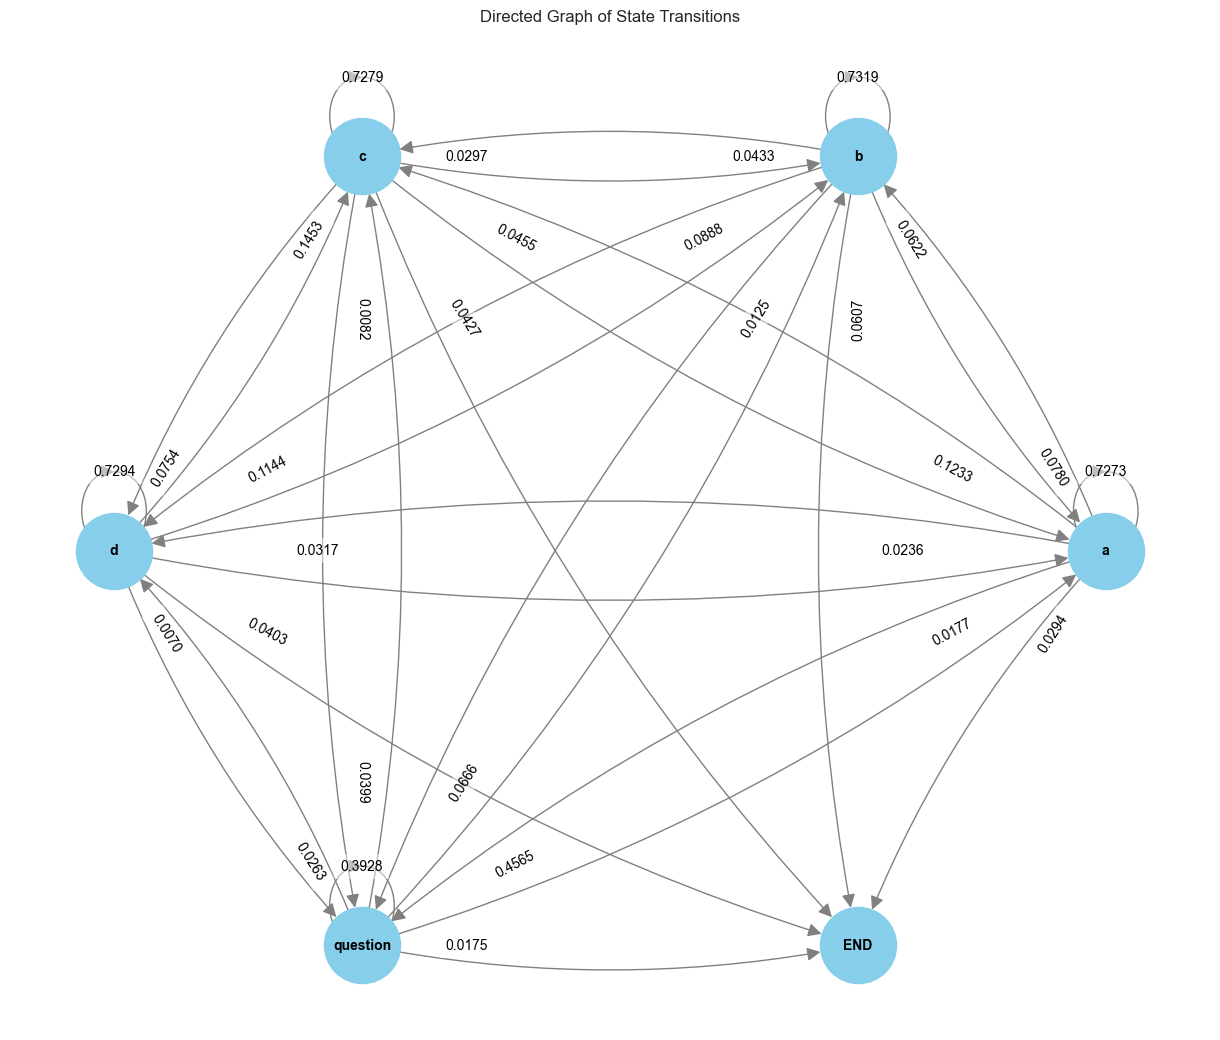

In [30]:
# Round probabilities to 4 decimal places
transition_matrix_prob = transition_matrix_prob.round(4)

# Create a directed graph
G = nx.DiGraph()

# Add nodes
for state in all_states + ['END']:
    G.add_node(state)

# Add edges with probabilities as weights
for from_state in all_states:
    for to_state in all_states + ['END']:
        weight = transition_matrix_prob.at[from_state, to_state]
        if weight > 0:
            G.add_edge(from_state, to_state, weight=weight)

# Position the nodes using a layout
pos = nx.circular_layout(G)#, seed=42)  # Using spring_layout for better distribution

# Draw the graph
plt.figure(figsize=(12, 10))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', 
        font_size=10, font_weight='bold', edge_color='gray', 
        arrows=True, arrowsize=20, connectionstyle='arc3,rad=0.1')

# Draw edge labels with weights
edge_labels = nx.get_edge_attributes(G, 'weight')
# Adjust label positions and set background color
nx.draw_networkx_edge_labels(
    G, pos, 
    edge_labels={k: f'{v:.4f}' for k, v in edge_labels.items()},
    label_pos=0.2,  # Adjust label position to be close to the arrow
    bbox=dict(facecolor='white', edgecolor='None', alpha=0.5),  # Background for labels
    verticalalignment='center',  # Align labels vertically
    horizontalalignment='center' # Align labels horizontally
)

plt.title('Directed Graph of State Transitions')
plt.show()


<h1><u>Simple Model</u> </h1>

In [31]:
# Convert `final_answer` to labels based on key columns
def map_final_answer(row):
    if row['ANSWER'] == '.':
        return None
    if row['a_key'] == row['ANSWER']:
        return 'a'
    elif row['b_key'] == row['ANSWER']:
        return 'b'
    elif row['c_key'] == row['ANSWER']:
        return 'c'
    elif row['d_key'] == row['ANSWER']:
        return 'd'
    return None

df['label'] = df.apply(map_final_answer, axis=1)

In [32]:
def aggregate_group(group):
    # Aggregate 'average_reading_time_by_length'
    # Since 'average_reading_time_by_length' contains float values, we'll take the mean for simplicity
    vectore = group['average_reading_time_by_length'].tolist()
    
    # Keep one 'has_preview' value (use the first non-NaN value)
    has_preview = group['has_preview'].dropna().iloc[0] if not group['has_preview'].dropna().empty else None
    
    # Keep one 'label' value (use the first non-NaN value)
    label = group['label'].dropna().iloc[0] if not group['label'].dropna().empty else None
    
    return pd.Series({
        'question':vectore[0],
        'a': vectore[1],
        'b': vectore[2],
        'c': vectore[3],
        'd': vectore[4],
        'has_preview': has_preview,
        'label': label
    })

In [33]:
# Create a sub-DataFrame
sub_df = df[['label', 'section', 'segmented', 'average_reading_time_by_length', 'has_preview']]

# Encode `has_preview` to binary
sub_df['has_preview'] = sub_df['has_preview'].astype(int)

# Remove duplicates
sub_df = sub_df.drop_duplicates()
grouped = sub_df.groupby(['section'])
aggregated_df = grouped.apply(aggregate_group).reset_index()
aggregated_df = aggregated_df.dropna(subset=['label'])
aggregated_df = aggregated_df.fillna(0)

# Prepare features and labels
features = aggregated_df[['question','a', 'b', 'c','d', 'has_preview']]
labels = aggregated_df['label']

# Encode labels to numerical values
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Normalize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [34]:


# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels_encoded, test_size=0.2, random_state=42)

# Train a simple model
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")

              precision    recall  f1-score   support

           a       0.90      0.73      0.80      3139
           b       0.14      0.13      0.14       331
           c       0.14      0.20      0.16       159
           d       0.05      0.43      0.09        72

    accuracy                           0.65      3701
   macro avg       0.31      0.37      0.30      3701
weighted avg       0.78      0.65      0.70      3701

Accuracy: 0.65


In [35]:
precision = {
    0: 0.90,
    1: 0.14,
    2: 0.14,
    3: 0.05
}

# Calculate inverse precision for weights
weights = {k: 1 / v for k, v in precision.items()}

# Normalize weights (optional, depending on the scale needed)
total_weight = sum(weights.values())
normalized_weights = {k: v / total_weight for k, v in weights.items()}
model = LogisticRegression(max_iter=1000, class_weight=normalized_weights)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")

              precision    recall  f1-score   support

           a       0.88      0.87      0.88      3139
           b       0.14      0.21      0.17       331
           c       0.17      0.01      0.01       159
           d       0.07      0.10      0.08        72

    accuracy                           0.76      3701
   macro avg       0.32      0.30      0.29      3701
weighted avg       0.77      0.76      0.76      3701

Accuracy: 0.76


In [36]:

# Train and evaluate models with different kernels
kernels = ['linear', 'poly', 'rbf']
for kernel in kernels:
    model = SVC(kernel=kernel, degree=3, gamma='scale',class_weight=normalized_weights)  # Degree for polynomial kernel, gamma for rbf kernel
    model.fit(X_train, y_train)
    
    # Predict and evaluate
    y_pred = model.predict(X_test)
    print(f"Kernel: {kernel}")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Kernel: linear
              precision    recall  f1-score   support

           a       0.86      0.94      0.90      3139
           b       0.15      0.13      0.14       331
           c       0.00      0.00      0.00       159
           d       0.00      0.00      0.00        72

    accuracy                           0.81      3701
   macro avg       0.25      0.27      0.26      3701
weighted avg       0.75      0.81      0.78      3701

Kernel: poly
              precision    recall  f1-score   support

           a       0.86      0.94      0.90      3139
           b       0.19      0.12      0.15       331
           c       0.08      0.01      0.01       159
           d       0.08      0.04      0.05        72

    accuracy                           0.81      3701
   macro avg       0.30      0.28      0.28      3701
weighted avg       0.75      0.81      0.78      3701

Kernel: rbf
              precision    recall  f1-score   support

           a       0.88      0.85  

<h1><u> RNN </u> </h1>

In [37]:
def remove_none_pairs(row):
    list1, list2 = row['reading_order_Segmentation'], ast.literal_eval(row['ordered_reading_times'])
    
    # Create new lists excluding None and the corresponding pair
    new_list1, new_list2 = [], []
    
    for v1, v2 in zip(list1, list2):
        if v1 is not None and v2 is not None:  # Check for None in either column
            new_list1.append(v1)
            new_list2.append(v2)
    
    return pd.Series([new_list1, new_list2])

In [38]:
sub_df = df[["segmented","ordered_reading_times","reading_order_Segmentation","section","has_preview","label","word_count_by_segment"]]
sub_df = sub_df.drop_duplicates()
sub_df['reading_order_Segmentation'] = sub_df["reading_order_Segmentation"].apply(remove_zeros)
sub_df[['reading_order_Segmentation', 'ordered_reading_times']] = sub_df.apply(remove_none_pairs, axis=1)

sub_df.head(200)


,segmented,ordered_reading_times,reading_order_Segmentation,section,has_preview,label,word_count_by_segment
0,question,"[163, 184, 363, 435, 229, 225, 716, 350, 316, ...","[question, a, a, a, a, c, c, c, d, d, b, b, b,...",1,1,a,4.0
4,a,"[163, 184, 363, 435, 229, 225, 716, 350, 316, ...","[question, a, a, a, a, c, c, c, d, d, b, b, b,...",1,1,a,7.0
11,b,"[163, 184, 363, 435, 229, 225, 716, 350, 316, ...","[question, a, a, a, a, c, c, c, d, d, b, b, b,...",1,1,a,7.0
18,c,"[163, 184, 363, 435, 229, 225, 716, 350, 316, ...","[question, a, a, a, a, c, c, c, d, d, b, b, b,...",1,1,a,7.0
25,d,"[163, 184, 363, 435, 229, 225, 716, 350, 316, ...","[question, a, a, a, a, c, c, c, d, d, b, b, b,...",1,1,a,8.0
...,...,...,...,...,...,...,...
1382,question,"[45, 189, 80, 245, 354, 340, 234, 340]","[question, a, a, c, b, d, d, d]",40,1,a,9.0
1391,a,"[45, 189, 80, 245, 354, 340, 234, 340]","[question, a, a, c, b, d, d, d]",40,1,a,5.0
1396,b,"[45, 189, 80, 245, 354, 340, 234, 340]","[question, a, a, c, b, d, d, d]",40,1,a,7.0
1403,c,"[45, 189, 80, 245, 354, 340, 234, 340]","[question, a, a, c, b, d, d, d]",40,1,a,7.0


In [39]:
# Step 1: Encode Categorical Variables
location_encoder = LabelEncoder()
sub_df['reading_order_encoded'] = sub_df['reading_order_Segmentation'].apply(lambda x: location_encoder.fit_transform(x))

label_encoder = LabelEncoder()
sub_df['label_encoded'] = label_encoder.fit_transform(sub_df['label'])


In [40]:
# Step 2: Prepare Sequences
sequences = []
labels = []

# Group by `section` to handle each sequence separately
for section, group in sub_df.groupby('section'):
    has_preview_value = group['has_preview'].iloc[0]  # Assuming has_preview is the same for all in a section
    label = group['label_encoded'].iloc[0]
    # Prepare the sequence for this section
    for idx, row in group.iterrows():
        sequence = []
        for loc, time in zip(row['reading_order_Segmentation'],row['ordered_reading_times'] ):
            # Find word_count for the corresponding segmented location
            try:
                word_count = group.loc[group['segmented'] == loc, 'word_count_by_segment'].iloc[0]
            except Exception :
                print("problem")
            # Build the feature vector for this step
            feature_vector = [
                location_encoder.transform([loc])[0],  # Encoded location
                time,                                 # Fixation time
                word_count,                           # Word count for the corresponding location
                has_preview_value                     # Has preview
            ]
            sequence.append(feature_vector)
        
        sequences.append(sequence)
        labels.append(label)  # The label is the same for the entire sequence


In [41]:
# Step 3: Padding Sequences
X = tf.keras.preprocessing.sequence.pad_sequences(sequences, padding='post', dtype='float32')
y = np.array(labels)

# Step 4: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
# Compute Class Weights
class_weights = compute_class_weight(class_weight='balanced', 
                                     classes=np.unique(y_train), 
                                     y=y_train)

# Convert to dictionary format
class_weights_dict = {i: weight*(1) for i, weight in enumerate(class_weights)}

In [43]:

# Step 1: Reshape your data if necessary
X_train_flat = X_train.reshape((X_train.shape[0], -1))  # Flatten the sequence data for undersampling

# Step 2: Apply Random UnderSampling
rus = RandomUnderSampler()
X_resampled, y_resampled = rus.fit_resample(X_train_flat, y_train)


# Step 3: Reshape the undersampled data back to its original shape
X_resampled = X_resampled.reshape((X_resampled.shape[0], X_train.shape[1], X_train.shape[2]))


In [44]:
# Step 5: Build the RNN Model for sequence-level classification
model_rnn = Sequential()
model_rnn.add(SimpleRNN(64, input_shape=(X_resampled.shape[1], X_resampled.shape[2]), return_sequences=False))  # Use return_sequences=False
model_rnn.add(Dropout(0.2))
model_rnn.add(Dense(32, activation='relu'))
model_rnn.add(Dense(len(np.unique(y_train)), activation='softmax'))  # Number of classes (sequence-level classification)

model_rnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Step 5: Train the Model
model_rnn.fit(X_resampled, y_resampled, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.2600 - loss: 1.3956 - val_accuracy: 0.1871 - val_loss: 1.3768
Epoch 2/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.2463 - loss: 1.3909 - val_accuracy: 0.2387 - val_loss: 1.3763
Epoch 3/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.2552 - loss: 1.4015 - val_accuracy: 0.0839 - val_loss: 1.4218
Epoch 4/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.2530 - loss: 1.4068 - val_accuracy: 0.1234 - val_loss: 1.4091
Epoch 5/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.2540 - loss: 1.3954 - val_accuracy: 0.0397 - val_loss: 1.4526
Epoch 6/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.2501 - loss: 1.3976 - val_accuracy: 0.6193 - val_loss: 1.2968
Epoch 7/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.2501 - loss: 1.3922 - val_accuracy: 0.2508 - val_loss: 1.3796
Epoch 8/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.2462 - loss: 1.3918 - val_accu

In [45]:
# Step 7: Evaluate the Model
loss, accuracy = model_rnn.evaluate(X_train, y_train)
print(f"Train Accuracy: {accuracy * 100:.2f}%")

2320/2320 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.2675 - loss: 1.3797
Train Accuracy: 26.75%


In [46]:
loss, accuracy = model_rnn.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

580/580 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2743 - loss: 1.3795
Test Accuracy: 26.90%


In [68]:
def permutation_test(X_test, y_test, model1, model2, n_permutations=1000):
    # Get predictions from both models
    y_pred1 = model1.predict(X_test)
    y_pred2 = model2.predict(X_test)
    y_pred2 = np.argmax(y_pred2, axis=1)  # Convert to class labels

    # Compute the observed difference in accuracy
    observed_accuracy_diff = accuracy_score(y_test, y_pred1) - accuracy_score(y_test, y_pred2)

    # Combine true labels and predictions
    y_test_labels, y_pred1_labels, y_pred2_labels = y_test, y_pred1, y_pred2
    accuracy_diffs = []

    for _ in range(n_permutations):
        # Shuffle the labels
        shuffled_y_test = shuffle(y_test_labels, random_state=42)
        
        # Compute accuracy for shuffled labels
        accuracy1 = accuracy_score(shuffled_y_test, y_pred1_labels)
        accuracy2 = accuracy_score(shuffled_y_test, y_pred2_labels)
        accuracy_diffs.append(accuracy1 - accuracy2)

    # Calculate p-value
    p_value = np.mean(np.abs(accuracy_diffs) >= np.abs(observed_accuracy_diff))
    return observed_accuracy_diff, p_value


Baseline Accuracy: 0.25460817074485287
580/580 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
RNN Model Accuracy: 0.2689985930919647
Classification Report for RNN Model:
               precision    recall  f1-score   support

           0       0.83      0.29      0.43     15593
           1       0.09      0.14      0.11      1666
           2       0.06      0.16      0.08       932
           3       0.02      0.43      0.04       363

    accuracy                           0.27     18554
   macro avg       0.25      0.25      0.16     18554
weighted avg       0.71      0.27      0.37     18554



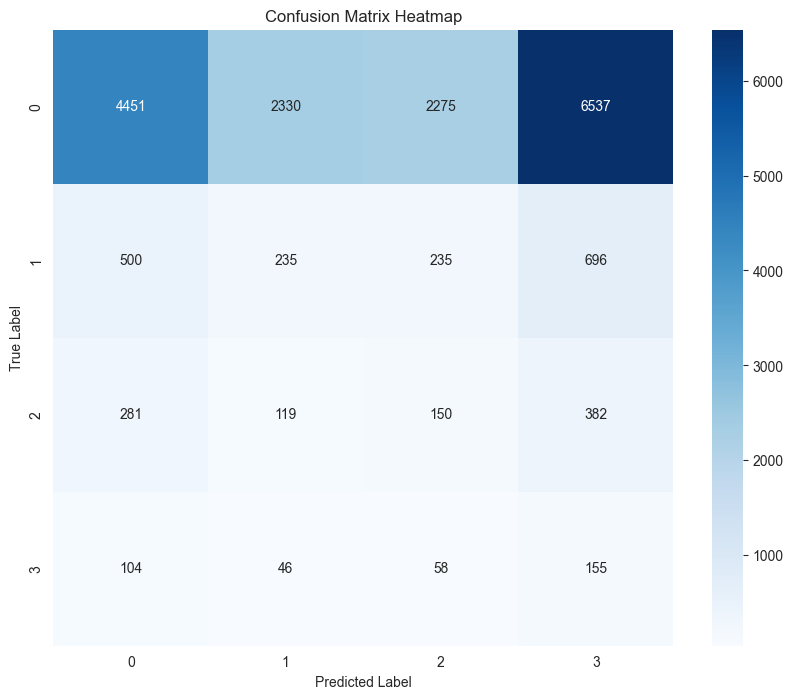

In [52]:

# Train a Baseline Model (Random Classifier)
baseline_model = DummyClassifier(strategy='uniform', random_state=42)  # Random classification
baseline_model.fit(X_train, y_train)
baseline_preds = baseline_model.predict(X_test)

# Evaluate the Baseline Model
baseline_accuracy = baseline_model.score(X_test, y_test)
print(f"Baseline Accuracy: {baseline_accuracy}")

# Step 4: Evaluate the RNN Model
y_pred = model_rnn.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
rnn_accuracy = model_rnn.evaluate(X_test, y_test, verbose=0)[1]
print(f"RNN Model Accuracy: {rnn_accuracy}")

# Detailed Classification Report
print("Classification Report for RNN Model:\n", classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()


In [69]:

# Step 5: Statistical Significance Testing 
# Get predictions from the baseline model
baseline_preds = baseline_model.predict(X_test)

# Get predictions from the GRU model
rnn_preds = model_rnn.predict(X_test)
rnn_preds = np.argmax(rnn_preds, axis=1)  # Convert to class labels

# Perform permutation test
accuracy_diff, p_value = permutation_test(X_test, y_test, baseline_model, model_rnn)

print(f"Observed Accuracy Difference: {accuracy_diff}")
print(f"Permutation Test p-value: {p_value}")


580/580 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
580/580 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Observed Accuracy Difference: -0.014390427940066841
Permutation Test p-value: 1.0


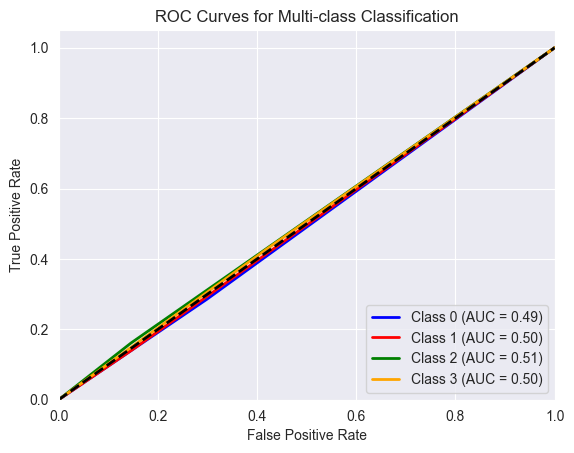

In [71]:


# Step 6: ROC Curves and AUC for Multi-class Classification
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_pred_bin = label_binarize(y_pred, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = ['blue', 'red', 'green', 'orange']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line for random guess
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multi-class Classification')
plt.legend(loc='lower right')
plt.show()

